In [2]:
import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
from deeprobust.graph.data import Dataset, PrePtbDataset
from deeprobust.graph.utils import preprocess, accuracy
from deeprobust.graph.defense import GCN

In [4]:
data = Dataset(root='./data/', name='cora', setting='prognn') 
perturbed_data = PrePtbDataset(root='./pertubed_data/',
                               name='cora',
                               attack_method='meta',
                               ptb_rate=0.15)

Loading cora dataset...
Selecting 1 largest connected components
Loading cora dataset perturbed by 0.15 meta...


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adj, features, labels = preprocess(data.adj, data.features, data.labels, preprocess_feature=True, device=device)
modified_adj = perturbed_data.adj
modified_adj, features, labels = preprocess(modified_adj, data.features, data.labels, preprocess_feature=True, device=device)

In [6]:
clean_edge_index = adj.nonzero().T
pertub_edge_index = modified_adj.nonzero().T

In [7]:
clean_edge_index

tensor([[   0,    0,    0,  ..., 2484, 2484, 2484],
        [1084, 1104, 1288,  ..., 1184, 1255, 1894]], device='cuda:0')

In [8]:
pertub_edge_index

tensor([[   0,    0,    0,  ..., 2484, 2484, 2484],
        [1084, 1104, 1288,  ..., 1184, 1255, 1894]], device='cuda:0')

In [51]:
mask = torch.zeros_like(pertub_edge_index[0]).bool()
for src, dst in tqdm(clean_edge_index.T):
    mask1 = torch.logical_and(pertub_edge_index[0] == src, pertub_edge_index[1] == dst)
    mask2 = torch.logical_and(pertub_edge_index[1] == src, pertub_edge_index[0] == dst)
    mask += mask1 + mask2

100%|██████████| 10138/10138 [00:01<00:00, 9291.67it/s]


In [52]:
torch.save(mask, './image/cora_real_mask')

In [20]:
train_acc = torch.load('./image/train_acc_mask')
train_acc_update = torch.load('./image/train_acc_mask_update')

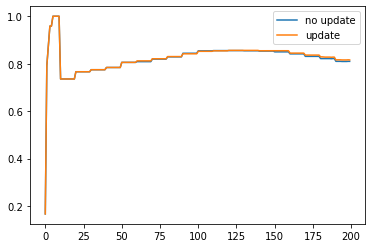

In [21]:
sns.lineplot(data=train_acc, label='no update')
sns.lineplot(data=train_acc_update, label='update')
plt.legend()

In [250]:
model_clean = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max().item()+1, dropout=0.5, lr=0.01, weight_decay=5e-4, device=device).to(device)
model_pertub = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max().item()+1, dropout=0.5, lr=0.01, weight_decay=5e-4, device=device).to(device)

In [275]:
model_clean.fit(features, adj, labels, data.idx_train, data.idx_val)
model_pertub.fit(features, modified_adj, labels, data.idx_train, data.idx_val)

In [276]:
model_clean.eval()
output_clean = model_clean.predict(features, adj).cpu()
acc_clean = accuracy(output_clean[data.idx_test], labels[data.idx_test]).cpu().item()
embed_clean = model_clean.get_embed(features, adj)
print(acc_clean)

0.7428909952606636


In [277]:
model_pertub.eval()
output_pertub = model_pertub.predict(features, modified_adj).cpu()
acc_pertub = accuracy(output_pertub[data.idx_test], labels[data.idx_test]).cpu().item()
embed_pertub = model_pertub.get_embed(features, modified_adj)
print(acc_pertub)

0.6190758293838863


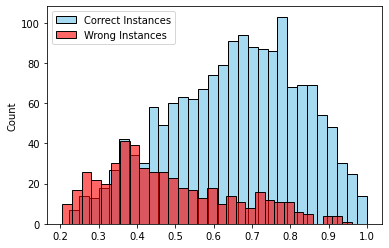

In [68]:
output = model_clean.predict().detach()
false_idx = labels != output.max(1).indices
sns.histplot(data=torch.exp(output.max(1).values[~false_idx].cpu()), 
bins=30, color="skyblue", label="Correct Instances")
sns.histplot(data=torch.exp(output.max(1).values[false_idx].cpu()), 
bins=30, color="red", label="Wrong Instances",  alpha=0.6)
plt.legend()

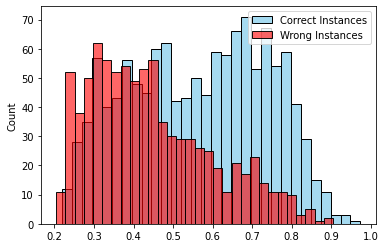

In [69]:
output = model_pertub.predict().detach()
false_idx = labels != output.max(1).indices
sns.histplot(data=torch.exp(output.max(1).values[~false_idx].cpu()), 
bins=30, color="skyblue", label="Correct Instances")
sns.histplot(data=torch.exp(output.max(1).values[false_idx].cpu()), 
bins=30, color="red", label="Wrong Instances",  alpha=0.6)
plt.legend()

In [70]:
embed_pertub = torch.nn.functional.normalize(embed_pertub)
inner_product_pertub = torch.mm(embed_pertub, embed_pertub.T)

<AxesSubplot:ylabel='Density'>

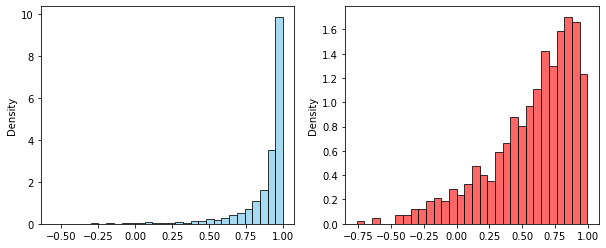

In [72]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, mask])].detach().cpu(), bins=30, color="skyblue", stat='density', label="Correct Instances")
ax1 = plt.subplot(122)
sns.histplot(data=inner_product_pertub[tuple(pertub_edge_index[:, ~mask])].detach().cpu(), bins=30, color="red", stat='density', label="Wrong Instances", alpha=0.6)

In [77]:
i = 0
edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
for src, dst in tqdm(clean_edge_index.cpu().T):
    edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
    mask1 = torch.logical_and(fake_edge_index[i][0] == src, fake_edge_index[i][1] == dst)
    mask2 = torch.logical_and(fake_edge_index[i][1] == src, fake_edge_index[i][0] == dst)
    mask += mask1 + mask2

mask = torch.logical_and(mask, ~edge_mask)

sns.histplot(data=fake_edge_weight[i][mask], bins=30, color='skyblue')
sns.histplot(data=fake_edge_weight[i][~mask], bins=30, color='red', alpha=0.6)

  0%|          | 0/7336 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (8750) must match the size of tensor b (114744) at non-singleton dimension 0

In [ ]:
i = -1
edge_mask = (fake_edge_index[i][0] >= 2485) + (fake_edge_index[i][1] >= 2485)
mask = torch.zeros_like(fake_edge_index[0, 0]).bool()
for src, dst in tqdm(clean_edge_index.cpu().T):
    mask1 = torch.logical_and(fake_edge_index[i][0] == src, fake_edge_index[i][1] == dst)
    mask2 = torch.logical_and(fake_edge_index[i][1] == src, fake_edge_index[i][0] == dst)
    mask += mask1 + mask2

mask = torch.logical_and(mask, ~edge_mask)

sns.histplot(data=fake_edge_weight[i][mask], bins=30, color='skyblue')
sns.histplot(data=fake_edge_weight[i][~mask], bins=30, color='red', alpha=0.6)

In [19]:
def _similarity(h1, h2=None):
    if h2 == None:
        h2 = h1
    h1 = torch.nn.functional.normalize(h1)
    h2 = torch.nn.functional.normalize(h2)
    return h1 @ h2.t()

C:\Users\user\anaconda3\envs\ImGAGN\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\envs\ImGAGN\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


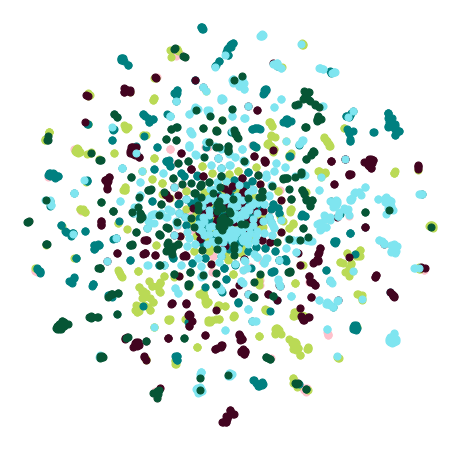

In [23]:
from sklearn.manifold import TSNE

z = TSNE(n_components=2).fit_transform(all_embeddings[15].numpy())
y = labels.cpu().numpy()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535','#ffd700']

plt.figure(figsize=(8, 8))
for i in range(y.max()+1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=50, color=colors[i])
plt.axis('off')
plt.show()

In [1]:
123

123